In [121]:
import glob 
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import cv2
from scipy.signal import find_peaks
import plotly.graph_objects as go
import plotly.express as px
import csv 
from PIL import Image
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [122]:
original_address = '/scratch/student/shokoofa/new_dataset'

In [123]:
df = pd.read_csv('labels.csv')

In [115]:
df

,label,combined
0,Subcostal,_3wRyUbdSGmjEWULRVg-jw 3
1,Subcostal,_3wRyUbdSGmjEWULRVg-jw 4
2,Subcostal,_3wRyUbdSGmjEWULRVg-jw 5
3,Subcostal,_3wRyUbdSGmjEWULRVg-jw 7
4,Subcostal,_3wRyUbdSGmjEWULRVg-jw 9
...,...,...
3813,Subcostal,6VLObFIMTzq7fyUz9-ltQA 74
3814,Subcostal,6VLObFIMTzq7fyUz9-ltQA 75
3815,Subcostal,6VLObFIMTzq7fyUz9-ltQA 77
3816,Suprasternal,6VLObFIMTzq7fyUz9-ltQA 78


In [116]:
df['label'].value_counts()

Apical-4ch      652
PLAX            617
Subcostal       580
PSAX-ves        462
Apical-3ch      337
Apical-2ch      292
Apical-5ch      211
PSAX-mid        192
PSAX-base       179
Suprasternal    168
PSAX-apical     128
Name: label, dtype: int64

In [117]:
df.combined.astype(str).str.split(' ')

0        [_3wRyUbdSGmjEWULRVg-jw, 3]
1        [_3wRyUbdSGmjEWULRVg-jw, 4]
2        [_3wRyUbdSGmjEWULRVg-jw, 5]
3        [_3wRyUbdSGmjEWULRVg-jw, 7]
4        [_3wRyUbdSGmjEWULRVg-jw, 9]
                    ...             
3813    [6VLObFIMTzq7fyUz9-ltQA, 74]
3814    [6VLObFIMTzq7fyUz9-ltQA, 75]
3815    [6VLObFIMTzq7fyUz9-ltQA, 77]
3816    [6VLObFIMTzq7fyUz9-ltQA, 78]
3817    [6VLObFIMTzq7fyUz9-ltQA, 79]
Name: combined, Length: 3818, dtype: object

In [118]:
df['patient'] = df['combined'].apply(lambda x : x.split(' ')[0])
# df.combined.astype(str).str.split(' ')[0]

In [119]:
total_class_counts = df['label'].value_counts()
total_class_counts

Apical-4ch      652
PLAX            617
Subcostal       580
PSAX-ves        462
Apical-3ch      337
Apical-2ch      292
Apical-5ch      211
PSAX-mid        192
PSAX-base       179
Suprasternal    168
PSAX-apical     128
Name: label, dtype: int64

In [ ]:
total_class_counts = df['label'].value_counts()

# Initialize dictionaries to keep track of class distribution in each split
train_class_counts = defaultdict(int)
val_class_counts = defaultdict(int)
test_class_counts = defaultdict(int)

# Initialize lists to keep track of patients in each split
train_patients = []
val_patients = []
test_patients = []

# Shuffle patients for random assignment
patients = df['patient'].unique()
np.random.shuffle(patients)

In [ ]:
# Function to check if a patient can be added to a split while respecting the constraints
def can_add_patient(patient, split_class_counts, max_fraction):
    patient_data = df[df['patient'] == patient]
    patient_class_counts = patient_data['label'].value_counts()
    
    for label, count in patient_class_counts.items():
        if split_class_counts[label] + count > (total_class_counts[label] * max_fraction):
            return False
    return True

In [ ]:
for patient in patients:
    if (len(train_patients) < 0.8 * len(patients)) and can_add_patient(patient, train_class_counts, 0.75):
        train_patients.append(patient)
        patient_data = df[df['patient'] == patient]
        for label in patient_data['label']:
            train_class_counts[label] += 1
    elif (len(val_patients) < 0.1 * len(patients)) and can_add_patient(patient, val_class_counts, 0.15):
        val_patients.append(patient)
        patient_data = df[df['patient'] == patient]
        for label in patient_data['label']:
            val_class_counts[label] += 1
    else:
        test_patients.append(patient)
        patient_data = df[df['patient'] == patient]
        for label in patient_data['label']:
            test_class_counts[label] += 1

In [ ]:
def rebalance_sets(source_set, target_set, source_class_counts, target_class_counts, target_max_fraction):
    patients_to_move = []
    for patient in source_set:
        if can_add_patient(patient, target_class_counts, target_max_fraction):
            patients_to_move.append(patient)
            patient_data = df[df['patient'] == patient]
            for label in patient_data['label']:
                target_class_counts[label] += 1
                source_class_counts[label] -= 1
    for patient in patients_to_move:
        source_set.remove(patient)
        target_set.append(patient)

In [ ]:
rebalance_sets(test_patients, val_patients, test_class_counts, val_class_counts, 0.1)

# Create the train, validation, and test DataFrames
train_df = df[df['patient'].isin(train_patients)]
val_df = df[df['patient'].isin(val_patients)]
test_df = df[df['patient'].isin(test_patients)]

# Verify the splits
print("Train set class distribution:")
print(train_df['label'].value_counts(normalize=True))
print("Validation set class distribution:")
print(val_df['label'].value_counts(normalize=True))
print("Test set class distribution:")
print(test_df['label'].value_counts(normalize=True))

# Plot the class distribution for each split
train_dist = train_df['label'].value_counts().sort_index()
val_dist = val_df['label'].value_counts().sort_index()
test_dist = test_df['label'].value_counts().sort_index()

Train set class distribution:
Apical-4ch      0.169163
Subcostal       0.158933
PLAX            0.153818
PSAX-ves        0.121301
Apical-3ch      0.088053
Apical-2ch      0.078188
Apical-5ch      0.053708
PSAX-mid        0.050420
PSAX-base       0.047863
Suprasternal    0.044574
PSAX-apical     0.033979
Name: label, dtype: float64
Validation set class distribution:
Apical-4ch      0.183857
PLAX            0.172646
Subcostal       0.141256
PSAX-ves        0.121076
Apical-3ch      0.085202
Apical-2ch      0.078475
Apical-5ch      0.053812
Suprasternal    0.049327
PSAX-mid        0.042601
PSAX-base       0.040359
PSAX-apical     0.031390
Name: label, dtype: float64
Test set class distribution:
PLAX            0.187402
Apical-4ch      0.168504
Subcostal       0.129134
PSAX-ves        0.119685
Apical-3ch      0.091339
Apical-2ch      0.067717
Apical-5ch      0.062992
PSAX-mid        0.055118
PSAX-base       0.047244
Suprasternal    0.037795
PSAX-apical     0.033071
Name: label, dtype: float

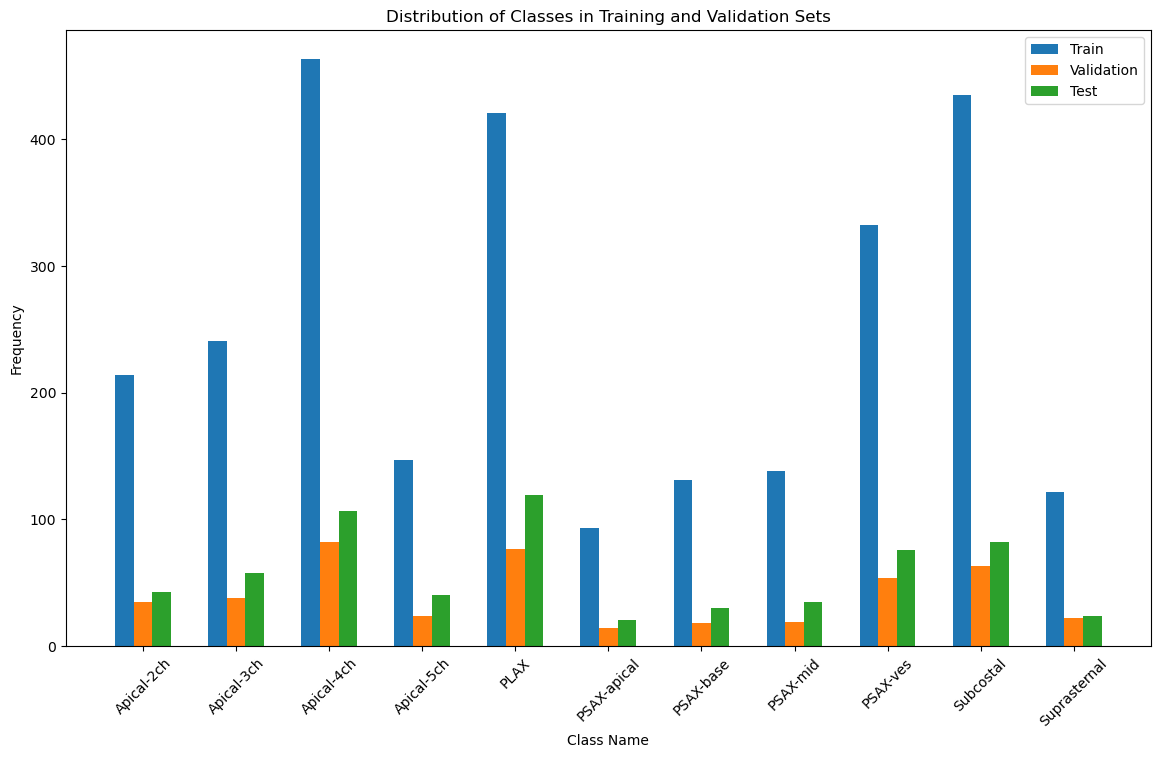

In [83]:
width = 0.2  # the width of the bars
fig, ax = plt.subplots(figsize=(14, 8))

train_pos = np.arange(len(train_dist))
val_pos = train_pos + width
test_pos = train_pos + 2 * width

ax.bar(train_pos, train_dist, width, label='Train')
ax.bar(val_pos, val_dist, width, label='Validation')
ax.bar(test_pos, test_dist, width, label='Test')

ax.set_xlabel('Class Name')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Classes in Training and Validation Sets')
ax.set_xticks(train_pos + width)
ax.set_xticklabels(train_dist.index, rotation=45)
ax.legend()

plt.show()


In [92]:
train_df[train_df['patient'].isin(test_df['patient']) == True]
val_df[val_df['patient'].isin(test_df['patient']) == True]
test_df[test_df['patient'].isin(val_df['patient']) == True]
test_df[test_df['patient'].isin(train_df['patient']) == True]

,label,combined,patient


In [98]:
assert len(set(train_patients).intersection(set(val_patients))) == 0
assert len(set(train_patients).intersection(set(test_patients))) == 0
assert len(set(val_patients).intersection(set(test_patients))) == 0

In [99]:
source_dir = original_address
train_dir = original_address + '/Train'
val_dir = original_address + '/Val'
test_dir = original_address + '/Test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [101]:
def move_patient_folders(patient_list, destination_dir):
    for patient in patient_list:
        src_path = os.path.join(source_dir, patient)
        dest_path = os.path.join(destination_dir, patient)
        if os.path.exists(src_path):
            shutil.move(src_path, dest_path)

In [102]:
move_patient_folders(train_patients, train_dir)
move_patient_folders(val_patients, val_dir)
move_patient_folders(test_patients, test_dir)

In [105]:
train_df['path'] = train_df['combined'].apply(lambda x : 'Train/' + ('/'.join(x.split(' '))))
val_df['path'] = val_df['combined'].apply(lambda x : 'Valid/' + ('/'.join(x.split(' '))))
test_df['path'] = test_df['combined'].apply(lambda x : 'Test/' + ('/'.join(x.split(' '))))

/tmp/ipykernel_145654/4010093788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['path'] = train_df['combined'].apply(lambda x : 'Train/' + ('/'.join(x.split(' '))))
/tmp/ipykernel_145654/4010093788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['path'] = val_df['combined'].apply(lambda x : 'Valid/' + ('/'.join(x.split(' '))))
/tmp/ipykernel_145654/4010093788.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [109]:
train_df.drop(['combined', 'patient'], axis= 1, inplace=True)
val_df.drop(['combined', 'patient'], axis= 1, inplace=True)
test_df.drop(['combined', 'patient'], axis= 1, inplace=True)

/tmp/ipykernel_145654/3268898502.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.drop(['combined', 'patient'], axis= 1, inplace=True)
/tmp/ipykernel_145654/3268898502.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['combined', 'patient'], axis= 1, inplace=True)


In [111]:
train_df.to_csv('train_labels_original.csv', index=False)
val_df.to_csv('val_labels_original.csv', index=False)
test_df.to_csv('test_labels_original.csv', index=False)

In [30]:
patients = df.patient.unique()

In [32]:
patient_class_distribution = df.groupby('patient')['label'].apply(lambda x: x.value_counts(normalize= True)).unstack(fill_value=0)
patient_class_distribution

,Apical-2ch,Apical-3ch,Apical-4ch,Apical-5ch,PLAX,PSAX-apical,PSAX-base,PSAX-mid,PSAX-ves,Subcostal,Suprasternal
patient,,,,,,,,,,,
-40uXj7VSHK4KVuHfAjiYQ,0.072727,0.072727,0.163636,0.036364,0.109091,0.036364,0.036364,0.054545,0.272727,0.036364,0.109091
-70W4j7aSF2wLzcVrXL4AA,0.068182,0.068182,0.204545,0.045455,0.136364,0.045455,0.045455,0.068182,0.136364,0.159091,0.022727
-8UKHE9bQ0u09nleXrwgBg,0.076923,0.128205,0.205128,0.076923,0.076923,0.025641,0.076923,0.076923,0.102564,0.102564,0.051282
-HQr6nOJRs6eFWVbflK-Mw,0.032258,0.096774,0.161290,0.032258,0.193548,0.032258,0.032258,0.064516,0.129032,0.193548,0.032258
-Lfio4cmRuiiQ2TgfNKtAg,0.025641,0.051282,0.205128,0.051282,0.256410,0.000000,0.025641,0.102564,0.076923,0.179487,0.025641
...,...,...,...,...,...,...,...,...,...,...,...
_XncWt7jRQuRDC-zj9V8Cg,0.106383,0.000000,0.255319,0.042553,0.255319,0.021277,0.042553,0.021277,0.127660,0.106383,0.021277
_fpOPq7mSyKI-q7AIVddew,0.117647,0.078431,0.196078,0.078431,0.117647,0.019608,0.019608,0.078431,0.137255,0.039216,0.117647
_kXOP1MSTci8eNMele9Atw,0.068966,0.068966,0.137931,0.068966,0.206897,0.034483,0.034483,0.034483,0.137931,0.137931,0.068966


In [33]:
train_patients, temp_patients = train_test_split(
    patients, 
    test_size=0.2, 
    stratify=patient_class_distribution, 
    random_state=42
)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
val_patients, test_patients = train_test_split(
    temp_patients, 
    test_size=0.5, 
    stratify=patient_class_distribution.loc[temp_patients], 
    random_state=42
)

In [ ]:
train_df = df[df['patient'].isin(train_patients)]
val_df = df[df['patient'].isin(val_patients)]
test_df = df[df['patient'].isin(test_patients)]